In [ ]:
# One Time Run only
import glob
import pandas as pd

# Merge the files for Spring2019

file_path = "/drive/My Drive/Fall24/IS733/IS733 - Project/Final Deliverables/UT1000_ema/UT1000_spring2019/*/ema_processed/daily_emas.csv"  # Updated file path pattern

all_files = glob.glob(file_path)

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

df.to_csv("/drive/My Drive/Fall24/IS733/IS733 - Project/Final Deliverables/Merged_Spring2019.csv", index=False)

In [ ]:
# One Time Run only

file_path = "/drive/My Drive/Fall24/IS733/IS733 - Project/Final Deliverables/UT1000_ema/UT1000_spring2019/*/ema_processed/momentary_emas.csv"  # Updated file path pattern

all_files = glob.glob(file_path)

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

df.to_csv("/drive/My Drive/Fall24/IS733/IS733 - Project/Final Deliverables/MergedMoments_Spring2019.csv", index=False)

# **Data Summary**

In [2]:
#Connect to Google drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
#Import the necessary Libraries

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans



In [4]:
df = pd.read_csv("/drive/My Drive/Fall24/IS733/IS733 - Project/Final Deliverables/Merged_Spring2019.csv")

In [5]:
df = df.drop(['Unnamed: 0'],axis=1)

In [6]:
df.shape

(55791, 5)

In [7]:
df.dtypes

,0
pid,object
survey.date,object
local.time,object
answer,int64
variable,object


In [8]:
df['survey.date'] = pd.to_datetime(df['survey.date'])
df['local.time'] = pd.to_datetime(df['local.time'])

In [9]:
df.dtypes


,0
pid,object
survey.date,datetime64[ns]
local.time,datetime64[ns]
answer,int64
variable,object


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55791 entries, 0 to 55790
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pid          55791 non-null  object        
 1   survey.date  55791 non-null  datetime64[ns]
 2   local.time   55791 non-null  datetime64[ns]
 3   answer       55791 non-null  int64         
 4   variable     55791 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 2.1+ MB


In [11]:
df.columns

Index(['pid', 'survey.date', 'local.time', 'answer', 'variable'], dtype='object')

In [12]:
for column in df.columns:
    unique_values = df[column].nunique()
    print(f"Column '{column}': {unique_values}")

Column 'pid': 423
Column 'survey.date': 77
Column 'local.time': 13816
Column 'answer': 13
Column 'variable': 8


In [13]:
def column_type(col):
    try:
        tempcol = pd.to_datetime(col, errors='ignore')
    except:
      pass


    if col.nunique() < 15:
      if pd.api.types.is_numeric_dtype(col):
            return 'Numeric'
      else:
            return 'Symbolic'
    elif col.name in ['Latitude', 'Longitude', 'Location']:
            return 'Spatial'
    elif pd.api.types.is_datetime64_any_dtype(tempcol):
        return 'Temporal'
    elif pd.api.types.is_numeric_dtype(col):
        return 'Numeric'
    else:
        return 'Other'
df_types = df.apply(column_type)
df_types

/tmp/ipython-input-13-4167217358.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  tempcol = pd.to_datetime(col, errors='ignore')
/tmp/ipython-input-13-4167217358.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tempcol = pd.to_datetime(col, errors='ignore')
/tmp/ipython-input-13-4167217358.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  tempcol = pd.to_datetime(col, errors='ignore')
/tmp/ipython-input-13-4167217358.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  tempcol = pd.to_datetime(

,0
pid,Other
survey.date,Temporal
local.time,Temporal
answer,Numeric
variable,Symbolic


In [14]:
df_types.value_counts()

,count
Temporal,2
Other,1
Numeric,1
Symbolic,1


In [15]:
df.describe()

,survey.date,local.time,answer
count,55791,55791,55791.000000
mean,2019-02-26 05:09:31.253427712,2019-02-26 23:24:41.102113280,1.962162
min,2019-02-14 00:00:00,2019-02-14 08:01:31,0.000000
25%,2019-02-19 00:00:00,2019-02-19 23:06:24,1.000000
50%,2019-02-25 00:00:00,2019-02-25 22:21:08,2.000000
75%,2019-03-03 00:00:00,2019-03-04 00:41:32,3.000000
max,2019-05-05 00:00:00,2019-05-05 13:25:13,12.000000
std,NaN,NaN,1.920023


In [16]:
df.isna().sum()

,0
pid,0
survey.date,0
local.time,0
answer,0
variable,0


In [17]:
pidf = df.pivot(index=['pid', 'survey.date', 'local.time'], columns='variable', values='answer').reset_index()
pidf.head(10)

variable,pid,survey.date,local.time,content,energy,lonely,refreshed,restful,sad,sleep,stress
0,1193rv5x,2019-02-14,2019-02-14 08:17:47,NaN,NaN,NaN,2.0,3.0,NaN,5.0,NaN
1,1193rv5x,2019-02-14,2019-02-14 23:51:50,3.0,3.0,2.0,NaN,NaN,1.0,NaN,1.0
2,1193rv5x,2019-02-15,2019-02-15 08:01:56,NaN,NaN,NaN,1.0,2.0,NaN,6.0,NaN
3,1193rv5x,2019-02-15,2019-02-15 20:32:55,2.0,3.0,3.0,NaN,NaN,2.0,NaN,1.0
4,1193rv5x,2019-02-16,2019-02-16 10:02:31,NaN,NaN,NaN,1.0,2.0,NaN,9.0,NaN
5,1193rv5x,2019-02-16,2019-02-16 20:02:33,1.0,2.0,3.0,NaN,NaN,2.0,NaN,1.0
6,1193rv5x,2019-02-17,2019-02-17 18:42:52,NaN,NaN,NaN,2.0,2.0,NaN,9.0,NaN
7,1193rv5x,2019-02-17,2019-02-17 20:09:34,1.0,1.0,3.0,NaN,NaN,3.0,NaN,2.0
8,1193rv5x,2019-02-18,2019-02-18 08:03:05,NaN,NaN,NaN,1.0,2.0,NaN,5.0,NaN
9,1193rv5x,2019-02-18,2019-02-18 20:04:01,3.0,3.0,1.0,NaN,NaN,1.0,NaN,1.0


In [18]:
pidf.isna().sum()

,0
variable,
pid,0
survey.date,0
local.time,0
content,7283
energy,7600
lonely,7297
refreshed,7065
restful,7070
sad,7289


[Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '7283'),
 Text(0, 0, '7600'),
 Text(0, 0, '7297'),
 Text(0, 0, '7065'),
 Text(0, 0, '7070'),
 Text(0, 0, '7289'),
 Text(0, 0, '7565'),
 Text(0, 0, '7288')]

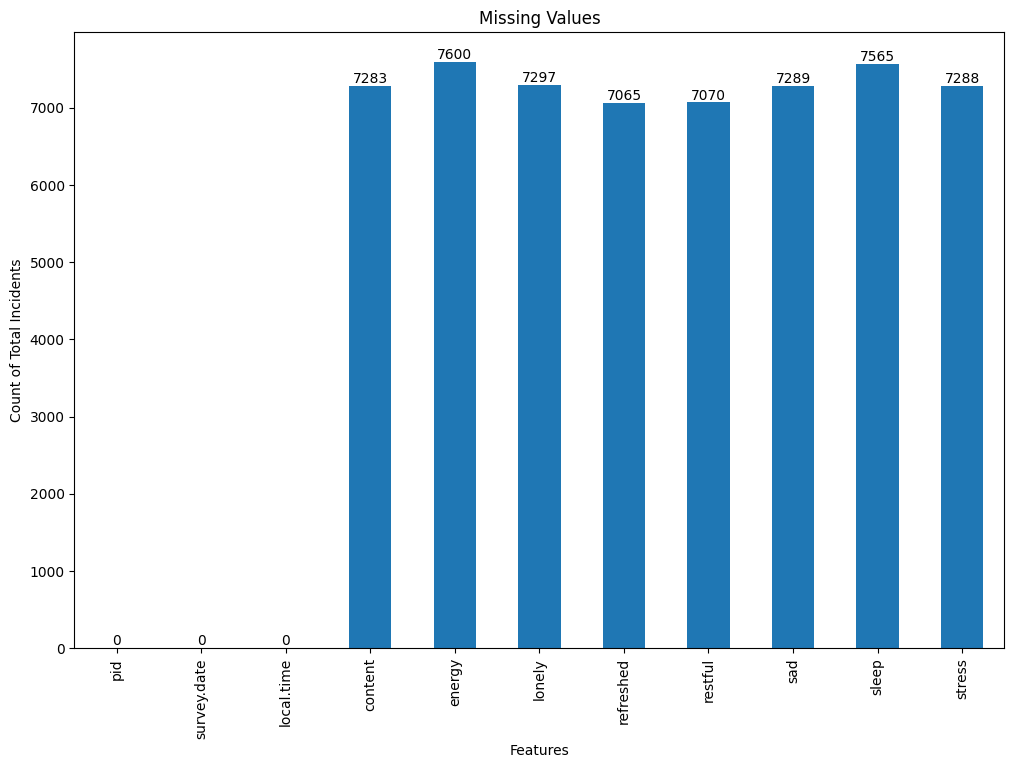

In [19]:
a = pidf.isna().sum().plot(kind='bar',rot='vertical', title='Missing Values', ylabel='Count of Total Incidents', xlabel='Features', figsize=(12, 8))
a.bar_label(a.containers[0])

In [20]:
cdf = pidf.groupby(['pid', 'survey.date'])[['content', 'energy', 'lonely','refreshed', 'restful', 'sad','sleep','stress']].max().reset_index() # merge duplicates by finding maximum value for that group
cdf.head()


variable,pid,survey.date,content,energy,lonely,refreshed,restful,sad,sleep,stress
0,1193rv5x,2019-02-14,3.0,3.0,2.0,2.0,3.0,1.0,5.0,1.0
1,1193rv5x,2019-02-15,2.0,3.0,3.0,1.0,2.0,2.0,6.0,1.0
2,1193rv5x,2019-02-16,1.0,2.0,3.0,1.0,2.0,2.0,9.0,1.0
3,1193rv5x,2019-02-17,1.0,1.0,3.0,2.0,2.0,3.0,9.0,2.0
4,1193rv5x,2019-02-18,3.0,3.0,1.0,1.0,2.0,1.0,5.0,1.0


In [21]:
cdf.isna().sum()

,0
variable,
pid,0
survey.date,0
content,1439
energy,1756
lonely,1453
refreshed,1277
restful,1285
sad,1445
sleep,1772


In [22]:
cdf.ffill(inplace=True)

In [23]:
cdf.isna().sum()

,0
variable,
pid,0
survey.date,0
content,0
energy,0
lonely,0
refreshed,0
restful,0
sad,0
sleep,0


In [24]:
duplicates = cdf[cdf.duplicated(subset=['pid', 'survey.date'], keep=False)]
print(duplicates)

Empty DataFrame
Columns: [pid, survey.date, content, energy, lonely, refreshed, restful, sad, sleep, stress]
Index: []


In [25]:
cdf.shape

(8437, 10)

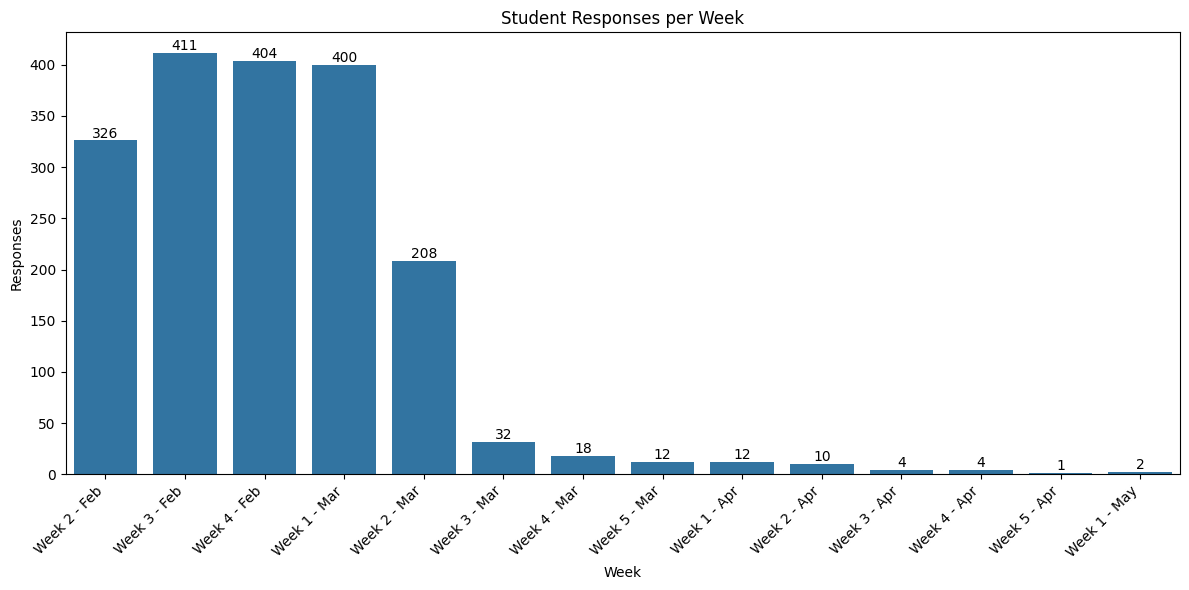

In [26]:
cdf['month'] = cdf['survey.date'].dt.month
cdf['day_of_month'] = cdf['survey.date'].dt.day
cdf['week_number'] = (cdf['day_of_month'] - 1) // 7 + 1
cdf['month_name'] = cdf['survey.date'].dt.month_name().str[:3]

weekly_pid_counts = cdf.groupby(['month', 'week_number', 'month_name'])['pid'].nunique().reset_index()
weekly_pid_counts['week_label'] = 'Week ' + weekly_pid_counts['week_number'].astype(str) + ' - ' + weekly_pid_counts['month_name']
weekly_pid_counts = weekly_pid_counts.sort_values(by=['month', 'week_number'])


plt.figure(figsize=(12, 6))
ax = sns.barplot(x='week_label', y='pid', data=weekly_pid_counts)

ax.grid(False)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.title('Student Responses per Week')
plt.xlabel('Week')
plt.ylabel('Responses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
weekly_pid_counts.head()

,month,week_number,month_name,pid,week_label
0,2,2,Feb,326,Week 2 - Feb
1,2,3,Feb,411,Week 3 - Feb
2,2,4,Feb,404,Week 4 - Feb
3,3,1,Mar,400,Week 1 - Mar
4,3,2,Mar,208,Week 2 - Mar


In [28]:
date_string = "2019-02-07"
min_survey_date = datetime.strptime(date_string, "%Y-%m-%d").date()

date_string = "2019-03-07"
max_survey_date = datetime.strptime(date_string, "%Y-%m-%d").date()
print(f"The survey dates range from {min_survey_date} to {max_survey_date}")

The survey dates range from 2019-02-07 to 2019-03-07


In [29]:
cdf = cdf[(cdf['survey.date'].dt.date >= min_survey_date) & (cdf['survey.date'].dt.date <= max_survey_date)]

# Response Rate

In [30]:
unique_months = cdf['survey.date'].dt.month.unique()
print(f"The unique months in the survey are: {unique_months}")

The unique months in the survey are: [2 3]


In [31]:
total_survey_dates = (max_survey_date - min_survey_date).days + 1
total_survey_dates

29

In [32]:
pid_counts = cdf.groupby('pid')['sad'].count().reset_index(name='response')
pid_counts['response_rate'] = (pid_counts['response'] / total_survey_dates) * 100
pid_counts.sort_values(by='response_rate', ascending=False, inplace=True)
pid_counts.head()

,pid,response,response_rate
420,srj6h857,22,75.862069
0,1193rv5x,22,75.862069
418,so63umwm,22,75.862069
402,rsyyg3ch,22,75.862069
395,rkd15kg7,22,75.862069


In [33]:
pid_counts.reset_index(inplace=True)
pid_counts.drop('index', axis=1, inplace=True)
pid_counts.head()

,pid,response,response_rate
0,srj6h857,22,75.862069
1,1193rv5x,22,75.862069
2,so63umwm,22,75.862069
3,rsyyg3ch,22,75.862069
4,rkd15kg7,22,75.862069


In [34]:
top_students = pid_counts[pid_counts['response']==22]['pid']
top_students

,pid
0,srj6h857
1,1193rv5x
2,so63umwm
3,rsyyg3ch
4,rkd15kg7
...,...
120,s6grzbhh
121,ryk13n49
122,1ayc6tix
123,18hwpo5x


In [35]:
total_students = pid_counts['pid'].nunique()
total = total_students*total_survey_dates

In [36]:
total_responses = pid_counts['response'].sum()

response_rate = total_responses / total
print(f"Response Rate: {response_rate:.2f}")


Response Rate: 0.61


In [37]:
pid_counts.shape

(422, 3)

In [38]:
rr = pid_counts.groupby('response').count().reset_index()

In [39]:
rr.head()

,response,pid,response_rate
0,1,2,2
1,2,6,6
2,3,2,2
3,4,5,5
4,5,3,3


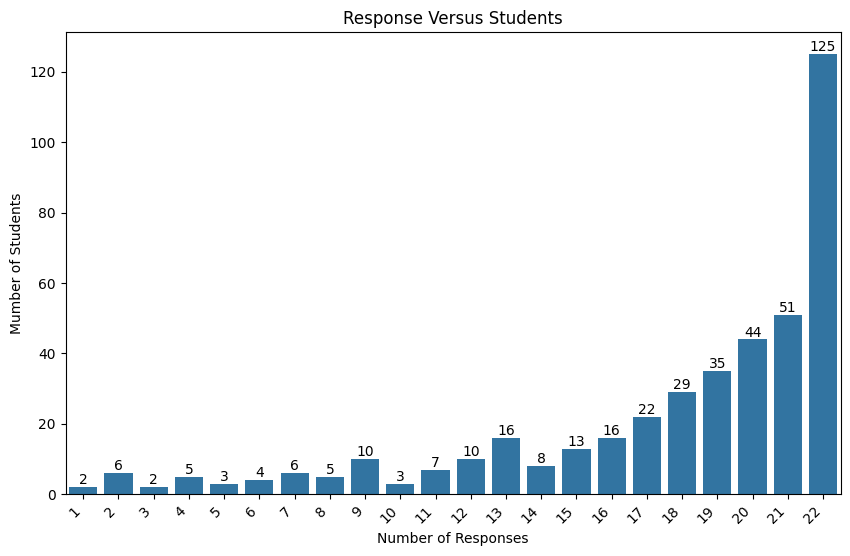

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x='response', y='pid', data=rr)
plt.title('Response Versus Students')
plt.xlabel('Number of Responses')
plt.ylabel('Mumber of Students')
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.show()


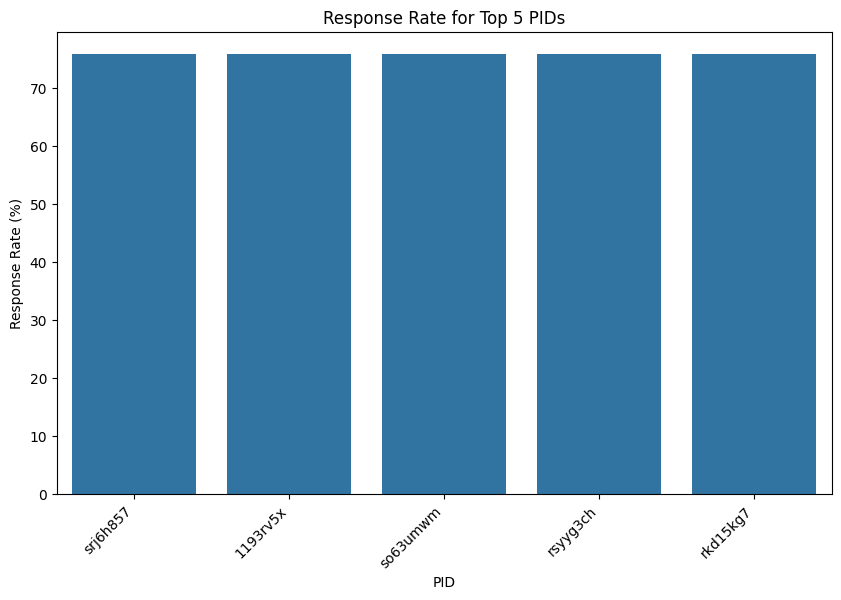

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x='pid', y='response_rate', data=pid_counts.head(5))
plt.title('Response Rate for Top 5 PIDs')
plt.xlabel('PID')
plt.ylabel('Response Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.show()

# **Modelling**

## Clustering

In [42]:
top_students.head()

,pid
0,srj6h857
1,1193rv5x
2,so63umwm
3,rsyyg3ch
4,rkd15kg7


In [43]:
top_students.nunique()

125

In [44]:
TopResponses = cdf[cdf['pid'].isin(top_students)]

In [45]:
gdf = TopResponses.groupby('pid')[['sad','stress','content','lonely']].mean().reset_index()

In [46]:
features_for_clustering = ['sad','stress','content','lonely']

X = gdf[features_for_clustering]

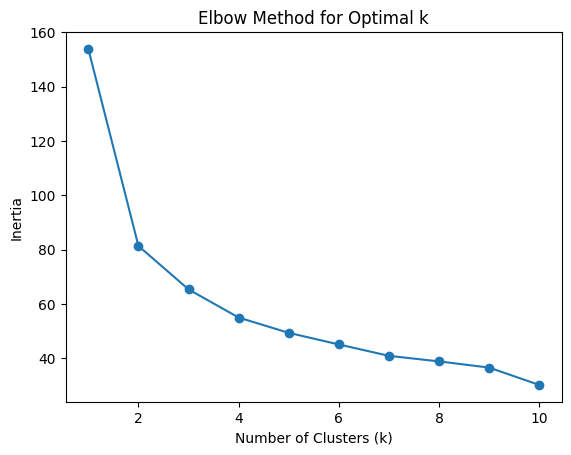

In [47]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [48]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
gdf['cluster'] = kmeans.fit_predict(X)

In [49]:
cluster_means = gdf.groupby('cluster')[features_for_clustering].mean()
print(cluster_means)

variable       sad    stress   content    lonely
cluster                                         
0         0.209957  0.701299  2.372294  0.187229
1         1.215618  1.597902  1.314685  1.181818
2         0.364669  1.334711  1.703512  0.282025


In [50]:
cluster_counts = gdf.groupby('cluster')['pid'].nunique().reset_index()
print(cluster_counts)

   cluster  pid
0        0   42
1        1   39
2        2   44


In [51]:
silhouette_avg = silhouette_score(X, gdf['cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.2729089395817035


In [52]:
gdf.head()

variable,pid,sad,stress,content,lonely,cluster
0,1193rv5x,1.772727,1.272727,1.681818,2.136364,1
1,15ir3is3,0.500000,0.181818,2.636364,0.181818,0
2,181my5xb,0.045455,1.272727,2.045455,0.000000,2
3,18hwpo5x,0.136364,1.363636,2.818182,0.045455,0
4,1ayc6tix,0.181818,0.863636,1.454545,0.227273,2


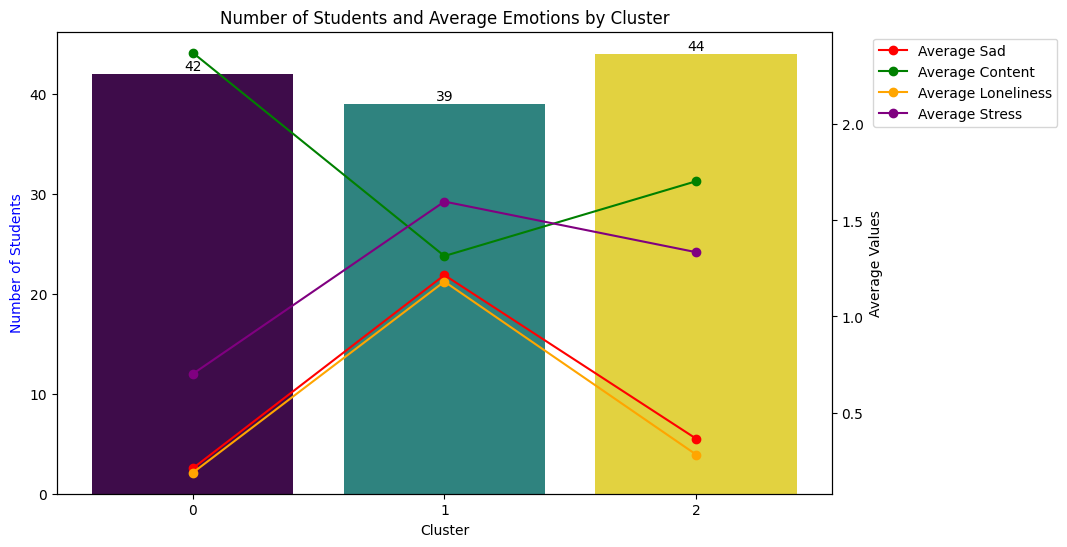

In [53]:
cluster_stats = gdf.groupby('cluster').agg(
    pid_count=('pid', 'nunique'),
    avg_sad=('sad', 'mean'),
    avg_content=('content', 'mean'),
    avg_lonely=('lonely', 'mean'),
    avg_stress=('stress', 'mean')
    )

fig, ax1 = plt.subplots(figsize=(10, 6))

ax = sns.barplot(
    x=cluster_stats.index,
    y=cluster_stats['pid_count'],
    hue=cluster_stats.index,
    palette='viridis',
    dodge=False,
    legend=False,
    ax=ax1
)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Students', color='blue')

ax2 = ax1.twinx()

ax2.plot(
    cluster_stats.index,
    cluster_stats['avg_sad'],
    marker='o', color='red',
    label='Average Sad'
)

ax2.plot(
    cluster_stats.index,
    cluster_stats['avg_content'],
    marker='o', color='green',
    label='Average Content'
)

ax2.plot(
    cluster_stats.index,
    cluster_stats['avg_lonely'],
    marker='o', color='orange',
    label='Average Loneliness'
)

ax2.plot(
    cluster_stats.index,
    cluster_stats['avg_stress'],
    marker='o', color='purple',
    label='Average Stress'
)

ax2.set_ylabel('Average Values', color='black')
ax2.legend(bbox_to_anchor=(1.05, 1),loc='upper right')


plt.title('Number of Students and Average Emotions by Cluster')
plt.legend(bbox_to_anchor=(1.30, 1),loc='upper right')


for p in ax.patches:

    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.show()

In [54]:
gdf.head()

variable,pid,sad,stress,content,lonely,cluster
0,1193rv5x,1.772727,1.272727,1.681818,2.136364,1
1,15ir3is3,0.500000,0.181818,2.636364,0.181818,0
2,181my5xb,0.045455,1.272727,2.045455,0.000000,2
3,18hwpo5x,0.136364,1.363636,2.818182,0.045455,0
4,1ayc6tix,0.181818,0.863636,1.454545,0.227273,2


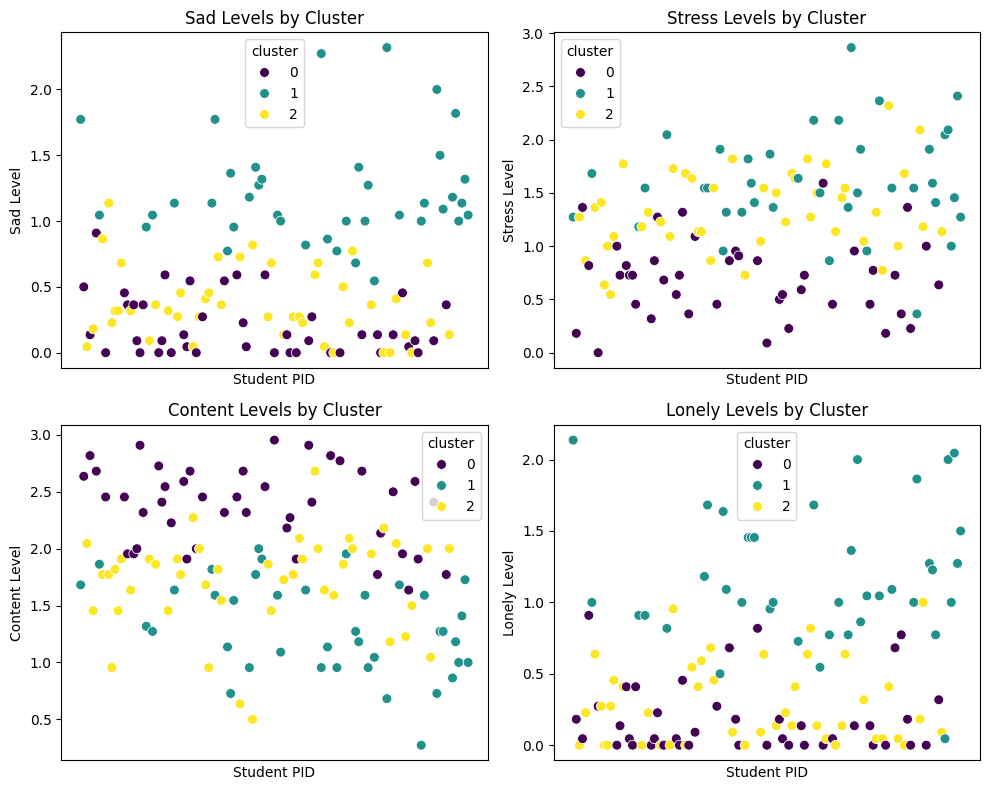

In [55]:
plot_data = gdf[['pid', 'cluster', 'sad', 'stress', 'content', 'lonely']].copy()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

variables = ['sad', 'stress', 'content', 'lonely']

for i, variable in enumerate(variables):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.scatterplot(x='pid', y=variable, hue='cluster', data=plot_data, palette='viridis', s=50, ax=ax)

    ax.set_title(f'{variable.capitalize()} Levels by Cluster')
    ax.set_xlabel('Student PID')
    ax.set_ylabel(f'{variable.capitalize()} Level')
    ax.set_xticks([])

plt.tight_layout()
plt.show()

# Trends -  Highly Stress Students

In [56]:
gdf.head(1), cdf.head(1)

(variable       pid       sad    stress   content    lonely  cluster
 0         1193rv5x  1.772727  1.272727  1.681818  2.136364        1,
 variable       pid survey.date  content  energy  lonely  refreshed  restful  \
 0         1193rv5x  2019-02-14      3.0     3.0     2.0        2.0      3.0   
 
 variable  sad  sleep  stress  month  day_of_month  week_number month_name  
 0         1.0    5.0     1.0      2            14            2        Feb  )

In [57]:
hss_pids = gdf[gdf['cluster']==1]['pid']
hss_pids
hss = cdf[cdf['pid'].isin(hss_pids)].reset_index().sort_values(by=['survey.date'])

In [58]:
a = hss.groupby('survey.date')[['stress','sad','lonely','content']].mean().reset_index()
a.tail()

variable,survey.date,stress,sad,lonely,content
17,2019-03-03,1.769231,1.333333,1.256410,1.153846
18,2019-03-04,1.641026,1.333333,1.102564,1.282051
19,2019-03-05,1.435897,1.205128,1.205128,1.282051
20,2019-03-06,1.717949,1.153846,1.076923,1.153846
21,2019-03-07,1.538462,1.205128,1.128205,1.307692


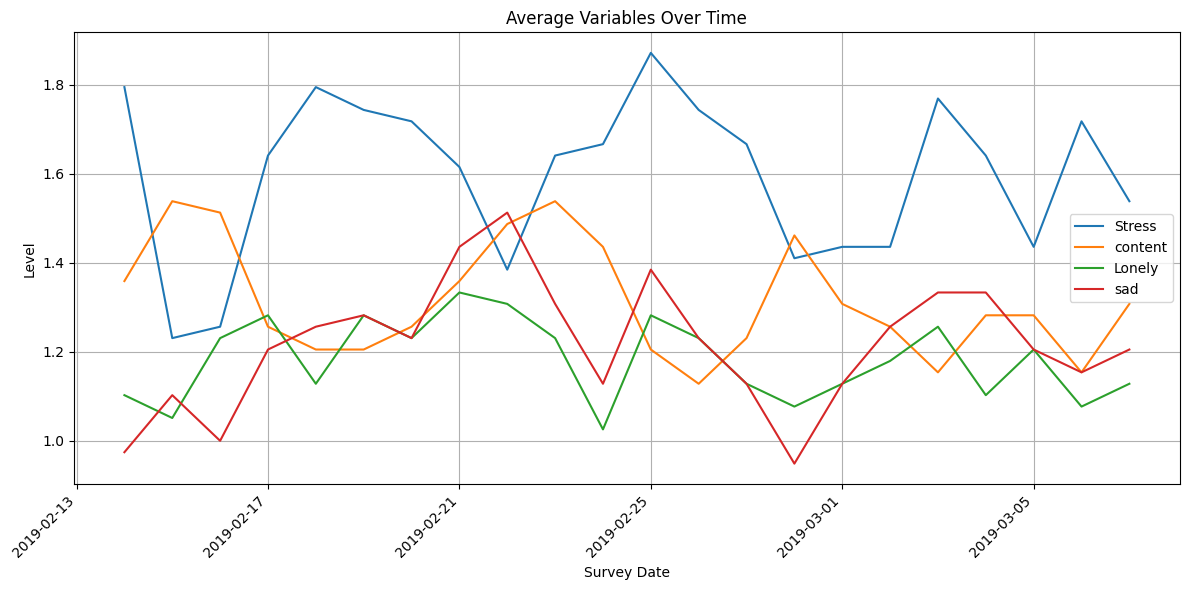

In [59]:
plt.figure(figsize=(12, 6))

plt.plot(a['survey.date'], a['stress'], label='Stress')
plt.plot(a['survey.date'], a['content'], label='content')
plt.plot(a['survey.date'], a['lonely'], label='Lonely')
plt.plot(a['survey.date'], a['sad'], label='sad')

plt.xlabel('Survey Date')
plt.ylabel('Level')
plt.title('Average Variables Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Exploring one highly stressed student

In [60]:
# get the pid for a student who is highly stressed with high response rate

In [61]:
hp = hss_pids.to_frame()
hp.reset_index(inplace=True,drop=True)
hp.head()

,pid
0,1193rv5x
1,2271yuw5
2,5fgthi1x
3,624l4j3w
4,934kcait


In [62]:
spid = hp['pid'][0]
spid

'1193rv5x'

In [63]:
Student1 = cdf[cdf['pid']==spid].reset_index()

In [64]:
Student1.head()

variable,index,pid,survey.date,content,energy,lonely,refreshed,restful,sad,sleep,stress,month,day_of_month,week_number,month_name
0,0,1193rv5x,2019-02-14,3.0,3.0,2.0,2.0,3.0,1.0,5.0,1.0,2,14,2,Feb
1,1,1193rv5x,2019-02-15,2.0,3.0,3.0,1.0,2.0,2.0,6.0,1.0,2,15,3,Feb
2,2,1193rv5x,2019-02-16,1.0,2.0,3.0,1.0,2.0,2.0,9.0,1.0,2,16,3,Feb
3,3,1193rv5x,2019-02-17,1.0,1.0,3.0,2.0,2.0,3.0,9.0,2.0,2,17,3,Feb
4,4,1193rv5x,2019-02-18,3.0,3.0,1.0,1.0,2.0,1.0,5.0,1.0,2,18,3,Feb


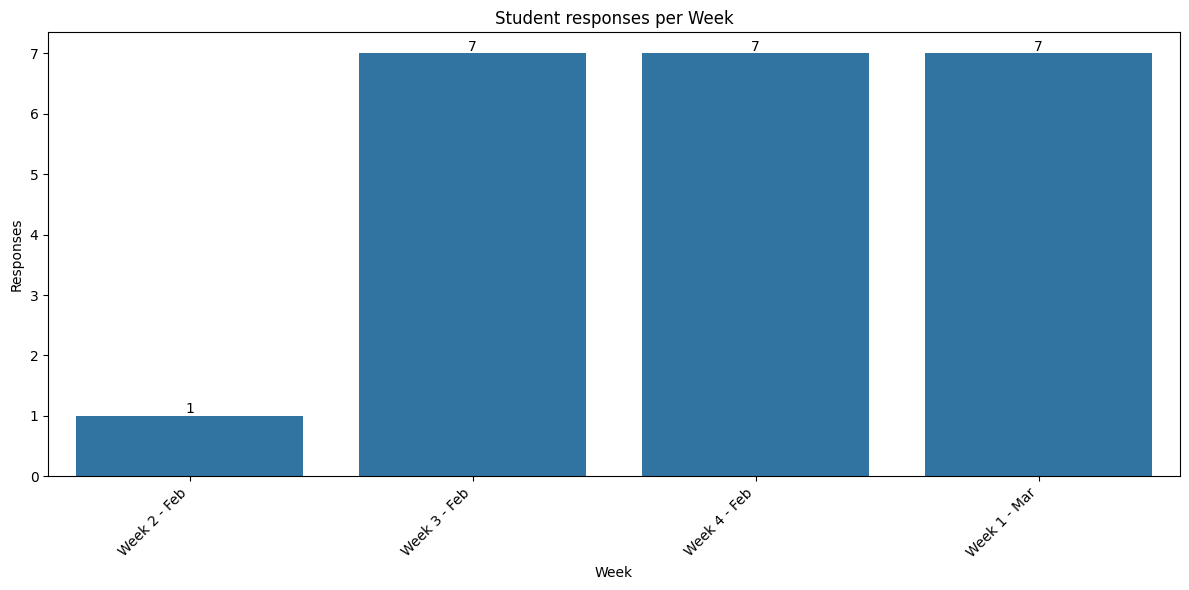

In [65]:
Student1['month'] = Student1['survey.date'].dt.month
Student1['day_of_month'] = Student1['survey.date'].dt.day
Student1['week_number'] = (Student1['day_of_month'] - 1) // 7 + 1
Student1['month_name'] = Student1['survey.date'].dt.month_name().str[:3]

weekly_response = Student1.groupby(['month', 'week_number', 'month_name'])['stress'].count().reset_index()
weekly_response['week_label'] = 'Week ' + weekly_response['week_number'].astype(str) + ' - ' + weekly_response['month_name']
weekly_response = weekly_response.sort_values(by=['month', 'week_number'])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='week_label', y='stress', data=weekly_response)

ax.grid(False)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.title('Student responses per Week')
plt.xlabel('Week')
plt.ylabel('Responses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Data Visualization**

<Axes: title={'center': 'SadnessLevels'}, xlabel='Month', ylabel='Avg Sadness'>

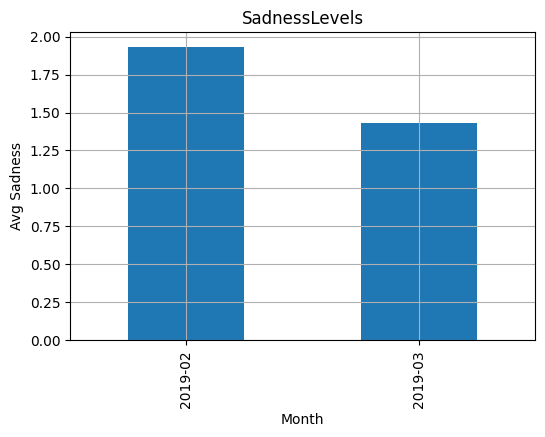

In [66]:

monthly_sad = Student1.groupby(Student1['survey.date'].dt.to_period('M'))['sad'].mean()
monthly_sad.plot(kind='bar', title='SadnessLevels', ylabel='Avg Sadness',xlabel='Month', figsize=(6, 4),grid=True)

## Relationship with Location and Activity

In [67]:
df2 = pd.read_csv("/drive/My Drive/Fall24/IS733/IS733 - Project/Final Deliverables/MergedMoments_Spring2019.csv")

In [68]:
df2.shape

(20849, 12)

In [69]:
df2.head()

,Unnamed: 0,pid,local.time,sad,stress,content,lonely,energy,where.at,with.whom,doing.what,interact.how
0,1,7zo5b6ma,2019-02-14 09:02:40,0,1,3,0,2,[Campus],[Classmates; students;Strangers],[Attending classes; meetings;Browsing the Inte...,[Not applicable; was not interacting with anyone]
1,2,7zo5b6ma,2019-02-14 13:59:52,0,1,2,0,2,[Campus],[Classmates; students;Friends],[Eating; drinking;Resting; napping; doing noth...,[Talking in person]
2,3,7zo5b6ma,2019-02-14 15:26:41,0,1,3,0,2,[Campus],[Friends;No one; alone;Strangers],[Attending classes; meetings;Studying; reading...,[Text messaging on the phone]
3,4,7zo5b6ma,2019-02-15 09:25:43,0,1,3,0,3,[Home (dorm; apartment)],[No one; alone],[Studying; reading; preparing for an exam;Talk...,[Text messaging on the phone]
4,5,7zo5b6ma,2019-02-15 12:29:39,0,0,3,0,4,[Bar; Party;Cafe; Restaurant;Work],[Classmates; students;Co-workers;Strangers],[Working at job],[Talking in person]


In [70]:
df2['local.time'] = pd.to_datetime(df2['local.time'])
df2['date'] = df2['local.time'].dt.date
df2['time'] = df2['local.time'].dt.time

In [71]:
df2.head()

,Unnamed: 0,pid,local.time,sad,stress,content,lonely,energy,where.at,with.whom,doing.what,interact.how,date,time
0,1,7zo5b6ma,2019-02-14 09:02:40,0,1,3,0,2,[Campus],[Classmates; students;Strangers],[Attending classes; meetings;Browsing the Inte...,[Not applicable; was not interacting with anyone],2019-02-14,09:02:40
1,2,7zo5b6ma,2019-02-14 13:59:52,0,1,2,0,2,[Campus],[Classmates; students;Friends],[Eating; drinking;Resting; napping; doing noth...,[Talking in person],2019-02-14,13:59:52
2,3,7zo5b6ma,2019-02-14 15:26:41,0,1,3,0,2,[Campus],[Friends;No one; alone;Strangers],[Attending classes; meetings;Studying; reading...,[Text messaging on the phone],2019-02-14,15:26:41
3,4,7zo5b6ma,2019-02-15 09:25:43,0,1,3,0,3,[Home (dorm; apartment)],[No one; alone],[Studying; reading; preparing for an exam;Talk...,[Text messaging on the phone],2019-02-15,09:25:43
4,5,7zo5b6ma,2019-02-15 12:29:39,0,0,3,0,4,[Bar; Party;Cafe; Restaurant;Work],[Classmates; students;Co-workers;Strangers],[Working at job],[Talking in person],2019-02-15,12:29:39


In [72]:
Student1 = cdf[cdf['pid']==spid].reset_index()
Student_ema = df2[df2['pid']==spid].reset_index()

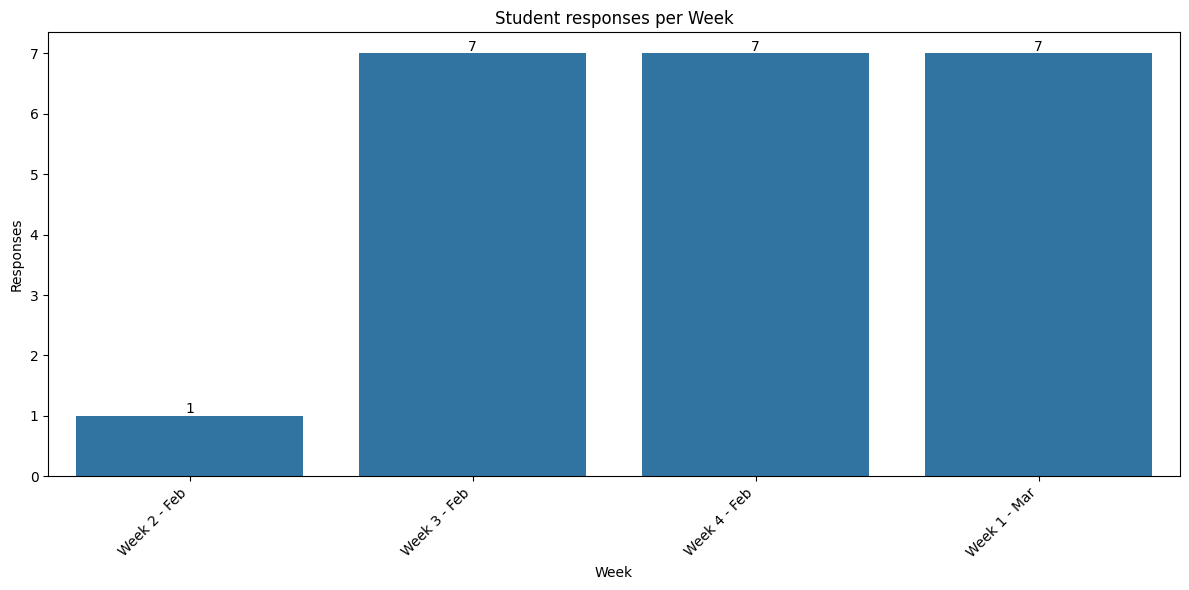

In [73]:
Student1['month'] = Student1['survey.date'].dt.month
Student1['day_of_month'] = Student1['survey.date'].dt.day
Student1['week_number'] = (Student1['day_of_month'] - 1) // 7 + 1
Student1['month_name'] = Student1['survey.date'].dt.month_name().str[:3]

weekly_response = Student1.groupby(['month', 'week_number', 'month_name'])['stress'].count().reset_index()
weekly_response['week_label'] = 'Week ' + weekly_response['week_number'].astype(str) + ' - ' + weekly_response['month_name']
weekly_response = weekly_response.sort_values(by=['month', 'week_number'])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='week_label', y='stress', data=weekly_response)

ax.grid(False)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.title('Student responses per Week')
plt.xlabel('Week')
plt.ylabel('Responses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [74]:
Student1['week_label'] = 'Week ' + Student1['week_number'].astype(str) + ' - ' + Student1['month_name']


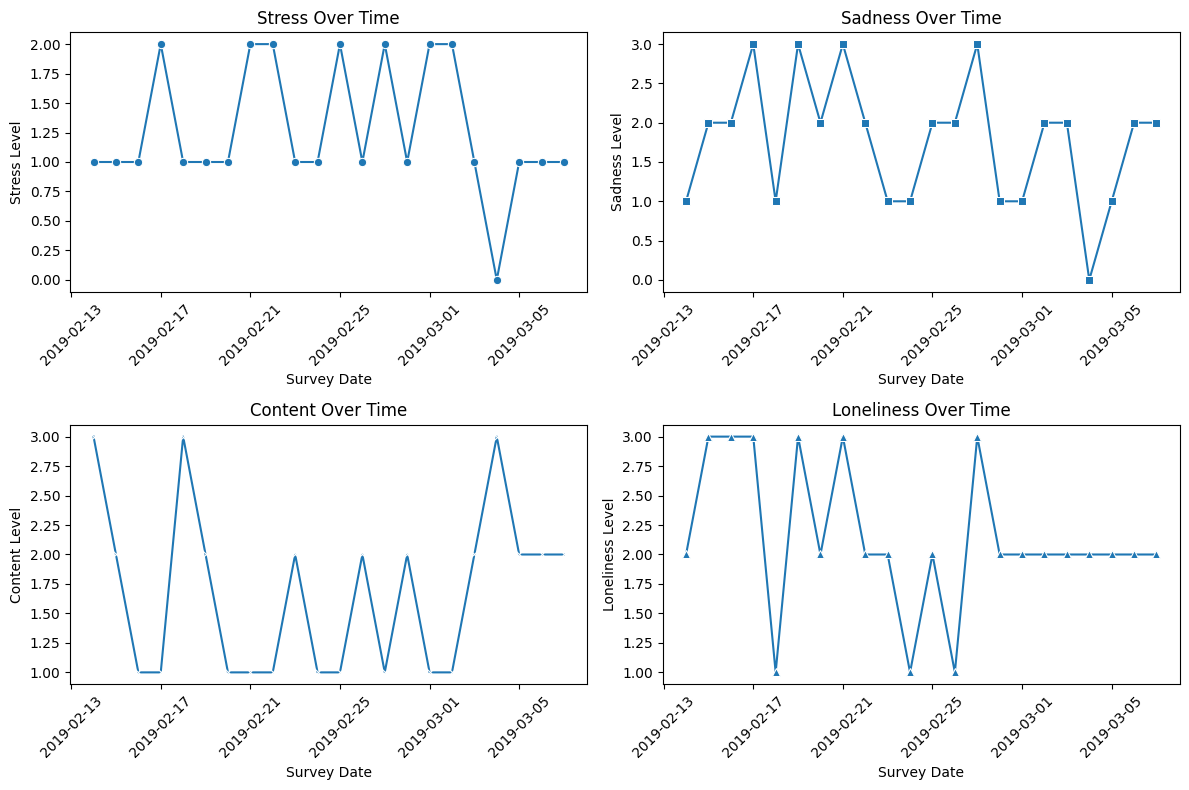

In [75]:


fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots

# Plot stress
sns.lineplot(x='survey.date', y='stress', data=Student1, marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Stress Over Time')
axes[0, 0].set_xlabel('Survey Date')
axes[0, 0].set_ylabel('Stress Level')

# Plot sad
sns.lineplot(x='survey.date', y='sad', data=Student1, marker='s', ax=axes[0, 1])
axes[0, 1].set_title('Sadness Over Time')
axes[0, 1].set_xlabel('Survey Date')
axes[0, 1].set_ylabel('Sadness Level')

# Plot content
sns.lineplot(x='survey.date', y='content', data=Student1, marker='x', ax=axes[1, 0])
axes[1, 0].set_title('Content Over Time')
axes[1, 0].set_xlabel('Survey Date')
axes[1, 0].set_ylabel('Content Level')

# Plot lonely
sns.lineplot(x='survey.date', y='lonely', data=Student1, marker='^', ax=axes[1, 1])
axes[1, 1].set_title('Loneliness Over Time')
axes[1, 1].set_xlabel('Survey Date')
axes[1, 1].set_ylabel('Loneliness Level')

# Adjust layout
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)  # Set rotation to 0 degrees

plt.tight_layout()
plt.show()

In [76]:
Student_ema['date'] = pd.to_datetime(Student_ema['date'])


In [77]:
import re
def process(row):
  loc = re.sub(r'[^\w\s]', '', row)
  return loc

In [78]:
Student_ema['where.at'] = Student_ema['where.at'].apply(process)
Student_ema['with.whom'] = Student_ema['with.whom'].apply(process)
Student_ema['doing.what'] = Student_ema['doing.what'].apply(process)

In [79]:
for i, row in Student_ema.iterrows():
  location = row['where.at'].lower()
  activity = row['doing.what'].lower()
  Student_ema.loc[i, 'apartment'] = 1 if 'apartment' in location else 0
  Student_ema.loc[i, 'dorm'] = 1 if 'dorm' in location else 0
  Student_ema.loc[i, 'Home'] = 1 if 'home' in location else 0
  Student_ema.loc[i, 'Campus'] = 1 if 'campus' in location else 0
  Student_ema.loc[i, 'Cafe'] = 1 if 'cafe' in location else 0
  Student_ema.loc[i, 'Restaurants'] = 1 if 'restaurant' in location else 0

  Student_ema.loc[i, 'chores'] = 1 if 'chores' in activity else 0
  Student_ema.loc[i, 'resting'] = 1 if 'resting' in activity else 0

  Student_ema.loc[i, 'movies'] = 1 if 'movies' in activity else 0
  Student_ema.loc[i, 'classes/meetings'] = 1 if 'meetings' in activity else 0
  Student_ema.loc[i, 'studying/exam'] = 1 if 'exam' in activity else 0
  Student_ema.loc[i, 'eating'] = 1 if 'eating' in activity else 0

  Student_ema.loc[i, 'socializing'] = 1 if 'socializing' in activity else 0
  Student_ema.loc[i, 'browsing'] = 1 if 'browsing' in activity else 0
  Student_ema.loc[i, 'working'] = 1 if 'working' in activity else 0
  Student_ema.loc[i, 'exercise'] = 1 if 'exercising' in activity else 0
  Student_ema.loc[i, 'traveling'] = 1 if 'traveling' in activity else 0

  Student_ema.loc[i, 'nothing'] = 1 if 'nothing' in activity else 0


In [80]:
Student_ema.columns

Index(['index', 'Unnamed: 0', 'pid', 'local.time', 'sad', 'stress', 'content',
       'lonely', 'energy', 'where.at', 'with.whom', 'doing.what',
       'interact.how', 'date', 'time', 'apartment', 'dorm', 'Home', 'Campus',
       'Cafe', 'Restaurants', 'chores', 'resting', 'movies',
       'classes/meetings', 'studying/exam', 'eating', 'socializing',
       'browsing', 'working', 'exercise', 'traveling', 'nothing'],
      dtype='object')

In [81]:
loc_cols = ['Home',
 'dorm',
 'apartment',
 'Campus',
 'Cafe',
 'Restaurants']

activity_cols = [
 'chores', 'resting', 'movies',
       'classes/meetings', 'studying/exam', 'eating', 'socializing',
       'browsing', 'working', 'exercise', 'traveling', 'nothing']

In [82]:
X= Student_ema[loc_cols]
y = Student_ema['stress']
y_sad = Student_ema['sad']
y_lonely = Student_ema['lonely']
y_content = Student_ema['content']

In [83]:

chi_scores, p_values = chi2(X, y)
chi_scores_sad, p_values_sad = chi2(X, y_sad)
chi_scores_lonely, p_values_lonely = chi2(X, y_lonely)
chi_scores_content, p_values_content = chi2(X, y_content)

In [84]:


data = pd.DataFrame({
    'Feature': loc_cols,
    'Stress': chi_scores,
    'Sad': chi_scores_sad,
    'Lonely': chi_scores_lonely,
    'Content': chi_scores_content
})

In [85]:
melted_data = pd.melt(data, id_vars=['Feature'], value_vars=['Stress', 'Sad', 'Lonely', 'Content'],
                     var_name='Emotion', value_name='Chi-Squared Score')

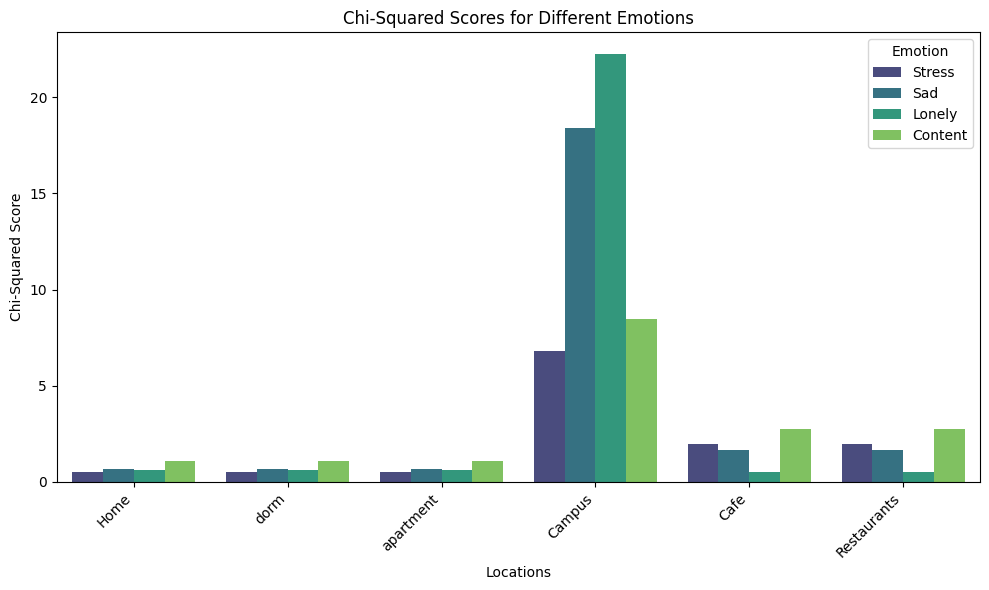

In [86]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Chi-Squared Score', hue='Emotion', data=melted_data, palette='viridis')
plt.title('Chi-Squared Scores for Different Emotions')
plt.xlabel('Locations')
plt.ylabel('Chi-Squared Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [87]:
X= Student_ema[activity_cols]
y = Student_ema['stress']
y_sad = Student_ema['sad']
y_lonely = Student_ema['lonely']
y_content = Student_ema['content']

In [88]:
chi_scores, p_values = chi2(X, y)
chi_scores_sad, p_values_sad = chi2(X, y_sad)
chi_scores_lonely, p_values_lonely = chi2(X, y_lonely)
chi_scores_content, p_values_content = chi2(X, y_content)

In [89]:
data = pd.DataFrame({
    'Feature': activity_cols,
    'Stress': chi_scores,
    'Sad': chi_scores_sad,
    'Lonely': chi_scores_lonely,
    'Content': chi_scores_content
})

In [90]:
melted_data = pd.melt(data, id_vars=['Feature'], value_vars=['Stress', 'Sad', 'Lonely', 'Content'],
                     var_name='Emotion', value_name='Chi-Squared Score')

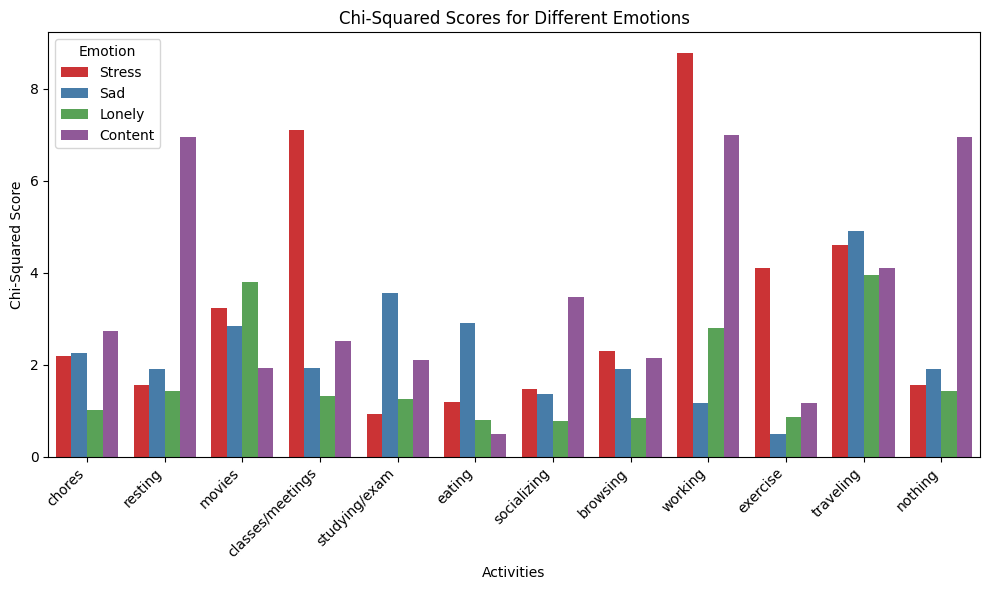

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Chi-Squared Score', hue='Emotion', data=melted_data, palette='Set1')
plt.title('Chi-Squared Scores for Different Emotions')
plt.xlabel('Activities')
plt.ylabel('Chi-Squared Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()